In [1]:
from __future__ import unicode_literals
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from helper_funcs import * 
import torch.nn as nn

import pandas as pd 
# prop = fm.FontProperties(fname='kalpurush ANSI.ttf')
# matplotlib.rcParams['font.family'] = prop.get_name()

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

from numpy import linalg as LA

import tensorboardX

batch_size=128
random_state = 42 

In [159]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tb_writer = tensorboardX.SummaryWriter('storage/2fc-sl')


cuda:0


In [160]:
df = pd.read_csv("data/label-mappings.csv")

In [161]:
df[df.label == 771]

,Unnamed: 0,grapheme_root,vowel_diacritic,consonant_diacritic,label
771,771,102,0,0,771


In [162]:
def get_accuracy(testloader, net, batch=False):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            
            gt = 0 
            vt = 0 
            ct = 0 
            
            if batch: 
                overall = 100 * correct / total
                
                for (pred, label) in zip(predicted, labels):                    
                    l = label.item()
                    p = pred.item()
                    g, v, c = df[df.label == l].grapheme_root.values[0], \
                        df[df.label == l].vowel_diacritic.values[0], \
                        df[df.label == l].consonant_diacritic.values[0]
                    
                    pg, pv, pc = df[df.label == p].grapheme_root.values[0], \
                        df[df.label == p].vowel_diacritic.values[0], \
                        df[df.label == p].consonant_diacritic.values[0]   
                    
                    if g == pg: 
                        gt += 1 
                    if v == pv: 
                        vt += 1
                    if c == pc: 
                        ct+=1 
                g_acc = 100*gt/batch_size
                v_acc = 100*vt/batch_size
                c_acc = 100*ct/batch_size
                overall = (g_acc*2 + v_acc + c_acc) /4 
                
                return g_acc, v_acc, c_acc, overall
                
    overall = 100 * correct / total
    
    return overall

In [163]:
transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

trainset = BengaliDataset("data/train.csv","data/trainsplit", transform)
testset = BengaliDataset("data/test.csv","data/testsplit", transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

df = pd.read_csv("data/train.csv")
classes = list(range(df.label.max()+1))
n_classes = len(classes)

In [164]:
images, labels,t = next(iter(trainloader))

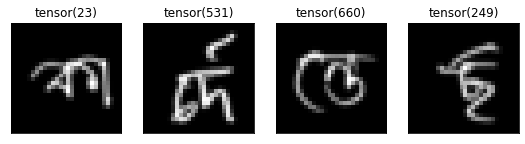

In [165]:
# show images
plot_gallery2(images,labels,1,4)

In [166]:
df.label.max()+1

1292

In [167]:
# Define our simple 2FC model:  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*13*13, 100)
        self.fc2 = nn.Linear(100, n_classes)
        self.ReLU = nn.ReLU()
        
        self.last_hidden = None

    def forward(self, x):
        x = self.conv(x)
        x = self.ReLU(x)
        x = self.pool(x)
        x = x.view(-1, 32*13*13)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_last_hidden(self,x):
        x = self.pool(self.ReLU(self.conv(x)))
        x = x.view(-1, 32*13*13)
        x = self.ReLU(self.fc1(x))
        return x 
    
net = Net().to(device)
output = net(images.to(device))

In [168]:
output.shape

torch.Size([128, 1292])

In [169]:
# Training with MSE/Quadratic loss 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

log_interval = 100
step = 0
# loop over the dataset multiple times
for epoch in range(20):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels, _ = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))        
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if (i+1) % log_interval == 0:    # print every 2000 mini-batches
            acc_g, acc_v, acc_c, overall = get_accuracy(testloader, net, batch=True)
            step_loss = running_loss / (log_interval+1)
            tb_writer.add_scalar("loss", loss, step)
            tb_writer.add_scalar("epoch_loss", running_loss, step)
            
            tb_writer.add_scalar("grapheme-root-accuracy", acc_g, step)
            tb_writer.add_scalar("vowel-diatric-accuracy", acc_v, step)
            tb_writer.add_scalar("consonant_diatric-accuracy", acc_c, step)
            tb_writer.add_scalar("accuracy", overall, step)


            print('[%d, %5d] loss: %.3f \t test accuracy: %.3f' % (epoch + 1, i + 1, loss, test_acc))
            
        step += 1 
                        

print('Finished Training')

[1,   100] loss: 7.170 	 test accuracy: 10.156
[1,   200] loss: 7.159 	 test accuracy: 10.156
[1,   300] loss: 7.162 	 test accuracy: 10.156
[1,   400] loss: 7.163 	 test accuracy: 10.156
[1,   500] loss: 7.176 	 test accuracy: 10.156
[1,   600] loss: 7.170 	 test accuracy: 10.156
[1,   700] loss: 7.184 	 test accuracy: 10.156
[1,   800] loss: 7.165 	 test accuracy: 10.156
[1,   900] loss: 7.170 	 test accuracy: 10.156
[1,  1000] loss: 7.158 	 test accuracy: 10.156
[2,   100] loss: 7.159 	 test accuracy: 10.156
[2,   200] loss: 7.171 	 test accuracy: 10.156
[2,   300] loss: 7.159 	 test accuracy: 10.156
[2,   400] loss: 7.168 	 test accuracy: 10.156
[2,   500] loss: 7.153 	 test accuracy: 10.156
[2,   600] loss: 7.162 	 test accuracy: 10.156
[2,   700] loss: 7.157 	 test accuracy: 10.156
[2,   800] loss: 7.155 	 test accuracy: 10.156
[2,   900] loss: 7.165 	 test accuracy: 10.156
[2,  1000] loss: 7.134 	 test accuracy: 10.156
[3,   100] loss: 7.158 	 test accuracy: 10.156
[3,   200] lo

[18,   400] loss: 4.945 	 test accuracy: 10.156
[18,   500] loss: 5.006 	 test accuracy: 10.156
[18,   600] loss: 5.082 	 test accuracy: 10.156
[18,   700] loss: 5.012 	 test accuracy: 10.156
[18,   800] loss: 4.883 	 test accuracy: 10.156
[18,  1000] loss: 4.847 	 test accuracy: 10.156
[19,   100] loss: 4.870 	 test accuracy: 10.156
[19,   200] loss: 5.289 	 test accuracy: 10.156
[19,   300] loss: 4.764 	 test accuracy: 10.156
[19,   400] loss: 4.790 	 test accuracy: 10.156
[19,   500] loss: 4.672 	 test accuracy: 10.156
[19,   600] loss: 5.069 	 test accuracy: 10.156
[19,   700] loss: 4.873 	 test accuracy: 10.156
[19,   800] loss: 4.966 	 test accuracy: 10.156
[19,   900] loss: 4.543 	 test accuracy: 10.156
[19,  1000] loss: 5.015 	 test accuracy: 10.156
[20,   100] loss: 5.043 	 test accuracy: 10.156
[20,   200] loss: 4.781 	 test accuracy: 10.156
[20,   300] loss: 4.947 	 test accuracy: 10.156
[20,   400] loss: 5.016 	 test accuracy: 10.156
[20,   500] loss: 4.848 	 test accuracy:

In [175]:
get_accuracy(testloader, net)

In [173]:
torch.save(net.state_dict(), "multilabel_fc2.pth")